In [1]:
from __future__ import print_function
%matplotlib inline
import pylab
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Ellipse
from sklearn import metrics
import random
import tables
import numpy as np
import tensorflow as tf
from sipm_param import *
import copy

NUM_ELPT = 1 # num points simulated in EL in same 'evt' 
nevts = 40000 # num events for each num EL pt
train_size = 35000
cv_size = 5000

# Geometry definition.
NSIPM = 8
sipm_pitch = 10.       # distance between SiPMs
sipm_edge_width = 5.   # distance between SiPM and edge of board

# Variables for computing an EL point location.
xlen = 2*sipm_edge_width + 7*sipm_pitch       # (mm) side length of rectangle
ylen = 2*sipm_edge_width + 7*sipm_pitch       # (mm) side length of rectangle
max_xy=2*sipm_edge_width + 7*sipm_pitch
wbin = 2.0                                    # (mm) bin width

# Compute the positions of the SiPMs.
pos_x = np.ones(NSIPM**2)*sipm_edge_width + (np.ones(NSIPM*NSIPM)*range(NSIPM**2) % NSIPM)*sipm_pitch
pos_y = np.ones(NSIPM**2)*sipm_edge_width + np.floor(np.ones(NSIPM*NSIPM)*range(NSIPM**2) / NSIPM)*sipm_pitch

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Generate El Hits

In [2]:
def make_xy():
    if NUM_ELPT == 1: X = np.random.uniform(0,max_xy,(nevts,NUM_ELPT))
    else:
        X = np.empty((nevts,NUM_ELPT),dtype=np.float32)
        
        #space x coordinates out so that the net can differentiate between pt1, pt2, etc
        for pt in range(NUM_ELPT): 
            X[:,pt] = np.random.uniform(pt*xlen/NUM_ELPT,(pt+1)*xlen/NUM_ELPT, nevts)
  
    Y = np.random.uniform(0,ylen,(nevts,NUM_ELPT))
    return X,Y
X,Y = make_xy()

Simulate SiPM responses:

In [3]:
def generate_sipm_responses(NUM_ELPT,X,Y):    
    sipm_res = np.zeros((nevts,NSIPM**2),dtype=np.float32) # SiPM responses
    
    evt = 0 
    for x,y in zip(X,Y):         # each event
        for xi,yi in zip(x,y):    # each hit
            r = np.sqrt((xi - pos_x)**2 + (yi - pos_y)**2)
            sipm_res[evt] = sipm_res[evt] + sipm_par(0,r) + sipm_par(1,r)
        evt +=1


    #Normalize for the DNN
    sipm_res /= 2 # for 2 timebins
    mean = np.mean(sipm_res)
    mean = 0
    std = np.std(sipm_res)
    return (sipm_res - mean)/std

sipm_res = generate_sipm_responses(NUM_ELPT,X,Y)

Divide data into training and cv

In [4]:
def make_training_groups(sipm_res,X,Y):
    # create training and cv data/labels. Note here they do not have to be preshuffled.
    data_train = sipm_res[0:train_size]
    data_cv    = sipm_res[train_size:(train_size + cv_size)]

    lbl = np.empty((nevts,NUM_ELPT*2),dtype=np.float32)
    lbl[:,0:NUM_ELPT] = X
    lbl[:,NUM_ELPT:2*NUM_ELPT] = Y
    lbl = (lbl - max_xy/2)/max_xy

    lbl_train = lbl[0:train_size]
    lbl_cv    = lbl[train_size:(train_size + cv_size)]
    return data_train, data_cv, lbl_train, lbl_cv

data_train, data_cv, lbl_train, lbl_cv = make_training_groups(sipm_res,X,Y)
print(data_train.shape,lbl_train.shape)
print(data_cv.shape,lbl_cv.shape)

(35000, 64) (35000, 2)
(5000, 64) (5000, 2)


Visualize input data:

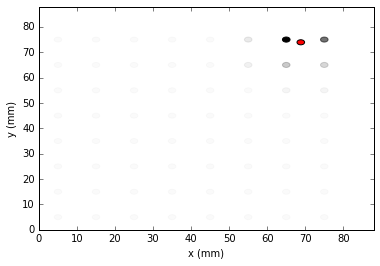

In [5]:
def plot2dim(data, lbl, predictions=None):   
    # Set up a plot.
    fig = plt.figure();
    ax1 = fig.add_subplot(111);
    ax1.axis([0, xlen*1.1, 0, ylen*1.1]);

    exevt = np.random.randint(lbl.shape[0])
    xpt = lbl[exevt,:NUM_ELPT]*max_xy + max_xy/2
    ypt = lbl[exevt,NUM_ELPT:]*max_xy + max_xy/2
    sipm_map = data[exevt]/np.max(data[exevt])  

    if   NUM_ELPT == 1: colors = ['r']
    elif NUM_ELPT == 2: colors = ['r','g']
    elif NUM_ELPT == 3: colors = ['r','g','b']
    elif NUM_ELPT == 4: colors = ['r','g','b','a']
  
    # Create circles and plot them according to the probabilities. 
    for x,y,p in zip(pos_x, pos_y, sipm_map):

        r = Ellipse(xy=(x,y), width=2., height=2.);
        r.set_facecolor('0');
        r.set_alpha(0.02 + 0.98*p); ##
        ax1.add_artist(r);
        #mrk = Ellipse(xy=(xpt[0],ypt[0]), width=2., height=2.);
        #mrk.set_facecolor('r');
        #ax1.add_artist(mrk);

    for pt in range(NUM_ELPT):
        mrk = Ellipse(xy=(xpt[pt],ypt[pt]), width=2., height=2.);
        mrk.set_facecolor(colors[pt]); ##
        ax1.add_artist(mrk);
    
    # if predictons given, plot them
    if type(predictions) != type(None):
        xpt = predictions[exevt,:NUM_ELPT]*max_xy + max_xy/2
        ypt = predictions[exevt,NUM_ELPT:]*max_xy + max_xy/2
        for pt in range(NUM_ELPT):
            print('Prediction Coordinates:')
            print(xpt[pt],ypt[pt])
            mrk = Ellipse(xy=(xpt[pt],ypt[pt]), width=2., height=2.);
            mrk.set_facecolor(colors[pt]); ##
            ax1.add_artist(mrk);


    # Show the plot.
    plt.xlabel("x (mm)");
    plt.ylabel("y (mm)");
    plt.show()

plot2dim(data_train,lbl_train)

Train with linear regression.. It still works.

In [6]:
from sklearn.linear_model import LinearRegression
def LinearReg(data_train,lbl_train,data_cv,lbl_cv,train_size):
    linreg = LinearRegression()
    linreg_model = linreg.fit(data_train, lbl_train[:train_size])
    print('----training now----')
    print('LinReg Score: %f' %linreg_model.score(data_cv,lbl_cv))

LinearReg(data_train,lbl_train,data_cv,lbl_cv,train_size)

----training now----
LinReg Score: 0.965362


Set up our own single layer net:

In [7]:
# setup architecture
batchsize = 64

# for convenience define a pair of functions to set up weight variables and bias variables
def weight_variable(shape):
    in_neurons = 1
    for ii in shape[:-1]: in_neurons *= ii
    out_neurons = shape[-1]
    init_rng = np.sqrt(3.0 / (in_neurons + out_neurons))    # change 3.0 to 6.0 to use with random_uniform
    #initial = tf.random_uniform(shape,minval=-init_rng,maxval=init_rng)
    initial = tf.truncated_normal(shape, stddev=init_rng)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.01, shape=shape)
    return tf.Variable(initial)

# set up the graph
def setup_linreg_graph():
    # It would be nice to add train_acc(uracy) and cv_acc so that these are calculated by tensorflow, but 
    # i haven't quite figured out how to make this work
    
    LinReg = tf.Graph()
    with LinReg.as_default():

        trainx  = tf.placeholder(tf.float32, [batchsize, NSIPM**2])    # SiPM response input for training
        trainy_ = tf.placeholder(tf.float32, [batchsize, NUM_ELPT*2]) # training labels (xcoord of EL HIT)

        W = weight_variable([NSIPM**2,NUM_ELPT*2])
        b = bias_variable([NUM_ELPT*2])

        train_yout = tf.matmul(trainx,W) + b  # predicted output for training data


        loss = tf.nn.l2_loss(train_yout - trainy_)
        optimizer = tf.train.GradientDescentOptimizer(0.0005).minimize(loss)

        #train_acc = 

        # for checking cross validation accuracy
        cvx     = tf.constant(data_cv)
        cvy_    = tf.constant(lbl_cv)  
        cv_yout = tf.matmul(cvx,   W) + b
        #cv_acc  = 
    return LinReg,trainx,trainy_,train_yout,loss,optimizer,cv_yout

Set up our own accuracy checker

In [8]:
# note accuracy can be negative
def accuracy(pred,lbls): 
    return metrics.r2_score(lbls, pred)

# error in average distance of a prediction point for its target
def error(pred,lbls):
    E=0.0
    for pt in range(NUM_ELPT):
        E = E + np.sqrt(
            np.sum(((lbls[:,pt] - pred[:,pt])*80)**2 + ((lbls[:,pt+NUM_ELPT] - pred[:,pt+NUM_ELPT])*80)**2)/lbls.shape[0])
    return E/NUM_ELPT

Now lets run it... 

In [9]:
def runTF(graph, numsteps, batchsize, data_train, lbl_train, lbl_cv, multidim=False):
    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        print("---Initialized---")

        for step in range(numsteps):
            # compute offset: //change this at some point
            offset = (step * batchsize) % (lbl_train.shape[0] - batchsize)

            # feed batch for training -- This could be improved by training over epochs
            # but for our purposes this should be sufficient
            batch_data = data_train[offset:(offset + batchsize), :]
            batch_labels = lbl_train[offset:(offset + batchsize), :]
            feed_dict = {trainx : batch_data, trainy_ : batch_labels}   # where to find batch data/lbls
            _, l, predictions = session.run([optimizer, loss, train_yout], feed_dict=feed_dict)

            # compute error every 5k iterations
            if step % 50000 == 0: 
                print('---Checking new accuracy---')
                print('loss: '+ str(l))
                if multidim:
                    print('training error: ' + str(error(predictions, batch_labels)))
                    cv_predictions = cv_yout.eval()
                    print('cv error      : ' + str(error(cv_predictions, lbl_cv)))
                else:      
                    print('training accuracy: ' + str(accuracy(predictions, batch_labels)))
                    cv_predictions = cv_yout.eval()
                    print('cv accuracy      : ' + str(accuracy(cv_predictions, lbl_cv)))
        return cv_predictions
numsteps = 100001

LinReg,trainx,trainy_,train_yout,loss,optimizer,cv_yout = setup_linreg_graph()
cv_predictions = runTF(LinReg, numsteps, batchsize, data_train, lbl_train, lbl_cv,multidim=True)

---Initialized---
---Checking new accuracy---
loss: 179.734
training error: 189.596487639
cv error      : 168.274195289
---Checking new accuracy---
loss: 0.162651
training error: 5.70352196553
cv error      : 6.14895392526
---Checking new accuracy---
loss: 0.241365
training error: 6.9478717976
cv error      : 6.13916168951


We could make the cv accuracy higher by tinkering with the learning rate/batch size/regularization, but for now the point is it works.

Prediction Coordinates:
10.5294 -0.254368


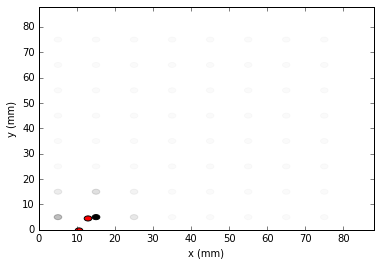

In [10]:
plot2dim(data_cv,lbl_cv,cv_predictions)

Now try with NUM_ELPT = 2 or 3

In [20]:
NUM_ELPT = 2

# prep data
X,Y = make_xy()
sipm_res = generate_sipm_responses(NUM_ELPT,X,Y)
data_train, data_cv, lbl_train, lbl_cv = make_training_groups(sipm_res,X,Y)

Try sklearn

In [21]:
LinearReg(data_train,lbl_train,data_cv,lbl_cv,train_size)

----training now----
LinReg Score: 0.949911


Try NN linear regression

In [22]:
# run
LinReg,trainx,trainy_,train_yout,loss,optimizer,cv_yout = setup_linreg_graph()
cv_predictions = runTF(LinReg, numsteps, batchsize, data_train, lbl_train, lbl_cv,multidim=True)

---Initialized---
---Checking new accuracy---
loss: 269.839
training error: 163.95559584
cv error      : 161.118534364
---Checking new accuracy---
loss: 0.409164
training error: 6.38140857552
cv error      : 5.83808252592
---Checking new accuracy---
loss: 0.322372
training error: 5.67604765946
cv error      : 5.84613182574


Prediction Coordinates:
3.47636 64.7407
Prediction Coordinates:
69.3604 51.3249


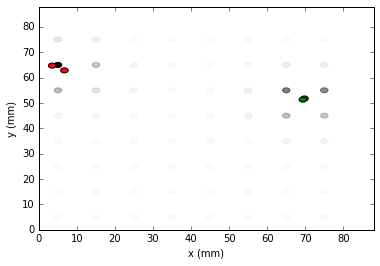

In [24]:
# graph sample
plot2dim(data_cv,lbl_cv,cv_predictions)

It works to some extent! Which is maybe slightly surprising. Still, the average error is a little over 7mm per point with 3 points, way too high. This could be improved by fine tuning some parameters, but it is better to just move to a bigger network, in keras.